### Multi head attention

Applying multiple attention in parallel and concatenating their results.

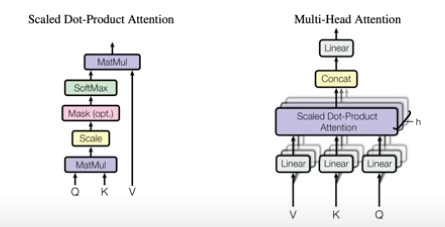

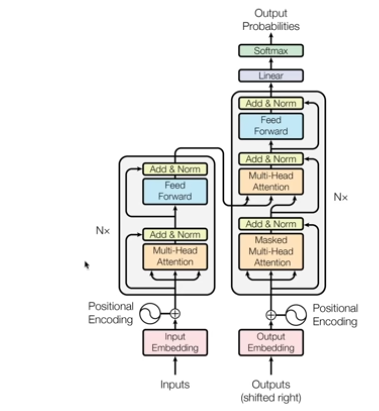

Deep neural nets suffer from optimization issues. In order to tackle that, there are 2 optimizations that dramatically help with the depth of these networks and make sure that the networks remain optimizable, lets talk about the first one

<br />

Think about the arrow that goes from below the masked multi head attention to the add & norm block and also the arrow from below the feed forward to the add & norm. They are called skip connections or residual connections.

<br />

It comes from the [deep residual learning for image recoginition](https://ieeexplore.ieee.org/document/7780459) from 2015, which basically says  that this connection comes in with the addition of previous features and this connection is added on the transformed data. During backpropogation distributes gradients equally to both of its branches that fed as input and so the supervision or the gradients from the loss basically hop through every addition node all the way to the input and also fork off into residual blocks but basically have this gradient way that goes directly from the supervision all the way to the input unimpeded and these visual blocks are usually intialised in the beginning so they contribute very little if anything to the residual pathway they are initialised that way, so in the beginning they are not present but then during optimization they come online over time and they start to contribute but at least at the initialisation you can go from directly supervision to the input gradient is unimpeded and just flows and then blocks over time kick in and so that dramatically helps with optimisation 


But the dimensionality of input nd output is 512 for them nd the feed forward has a dimension of 2048, so there is a multiplier of 4, SO THE INNER LAYER OF THE FEED FORWARD NET WITH DIMENSIONALITY 2048 MUST BE x by 4

Once we do this, we see the train loss is getting way ahead of validation loss, kind of like a overfitting 

In the diagram addition refers to residual part

But Norm is referring to something called Norm so [layer Norm](https://arxiv.org/abs/1607.06450) is implemented.
<br />
This norm is very much similar to the batch norm. Batch normalization just made sure that across the batch dimension any individual neuron had unit Gaussian distribution so it was 0 mean, unit SD and unit SD output. Normalising every single column of the input since the rows are normalized by default because we are just normalizing columns <br />

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [6]:
class BatchNormId:
    def __init__(self, dim, eps = 1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # paramters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean
            xvar = x.var(0, keepdim = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    
    def parameters(self):
        return [self.gamma, self.beta]
    
torch.manual_seed(1337)
module = BatchNormId(100)
x = torch.randn(32, 100) # initialise, a batch of 32 100 dimensional vectors feeding through the batch layer.
x = module(x)
x.shape


torch.Size([32, 100])

In [7]:
x[:, 0].mean(), x[:,0].std() # mean, std of one feature across all batch inputs

(tensor(7.4506e-09), tensor(1.0000))

Now we have got a 0 mean, 1 standard deviation so its normalising every single column of this input. 

In [9]:
x[0, :].mean(), x[0, :].std() # mean, std of a single input from the batch, of its features

(tensor(0.0411), tensor(1.0431))

The rows are not going to be normalised by default because we are just normalising the columns.

In [17]:
class LayerNormId:
    def __init__(self, dim, eps = 1e-5, momentum=0.1):
        self.eps = eps
        # paramters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)        
    
    def __call__(self, x):
        # calculate the forward pass
        # normalising the rows
        # no distinction between training and testing time
        xmean = x.mean(1, keepdim = True) #  mean
        xvar = x.var(1, keepdim = True) #  variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # we dont need the buffers because we can always apply this operationa nd dont need to maintain any running buffers
        return self.out
    
    
    def parameters(self):
        return [self.gamma, self.beta]
    
torch.manual_seed(1337)
module = LayerNormId(100)
x = torch.randn(32, 100) # initialise, a batch of 32 100 dimensional vectors feeding through the batch layer.
x = module(x)
x.shape


torch.Size([32, 100])

In [18]:
x[:, 0].mean(), x[:,0].std() 

(tensor(0.1469), tensor(0.8803))

In [19]:
x[0, :].mean(), x[0, :].std()

(tensor(-9.5367e-09), tensor(1.0000))

Therefore columns are not going to be normalised, but the rows are going to be normalised.

This is very much identical to this

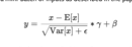

There is not much of a change from the paper we have studied that has come for the transformers but this is a big change... Earlier, we apply the add and norm after the transformation, now its common to apply the layer norm before the transformation so there is a reshuffing of layer norms and this is called prenorm formulation. 

Learn about [dropout](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf).

It just takes your neural net and it randomly for every forward backward pass shuts off some subset of neurons so randomly drops them to 0 and trains without them and what this does effectively is because the mask of whats being dropped out is changed every single forward backward pass,it ends up kind of training an ensemble of sub networks and then at test time everything is fully enabled and kind of all of those sub networks are merged into a single ensemble. This is a regularisation technique